In [152]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import statsmodels.api as sm

In [63]:
x = np.array([-4,-2,2,4,-4])
y = np.array([0,2,2,0,0])

data = np.array([x,y,np.ones(len(x))])
trans = np.array([[1,0,2],
                 [0,1,3],
                 [0,0,1]])

out = np.dot(trans,data)
x1 = out[0,:]
y1 = out[1,:]

data = np.array([x,y,np.ones(len(x))])

rot = np.array([[np.cos(np.deg2rad(30)),np.sin(np.deg2rad(30)),2],
                [-np.sin(np.deg2rad(30)),np.cos(np.deg2rad(30)),3],
                 [0,0,1]])
out = np.dot(rot,data)
x2 = out[0,:]
y2 = out[1,:]
print(out)


[[-1.46410162  1.26794919  4.73205081  5.46410162 -1.46410162]
 [ 5.          5.73205081  3.73205081  1.          5.        ]
 [ 1.          1.          1.          1.          1.        ]]


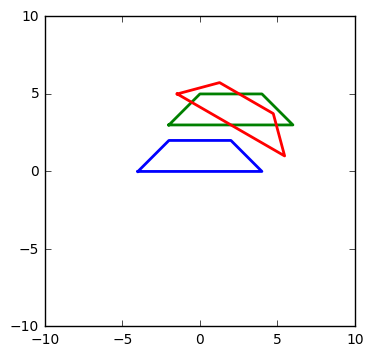

In [64]:
fig, ax = plt.subplots()
ax.plot(x,y,'b',lw=2)
ax.plot(x1,y1,'g',lw=2)
ax.plot(x2,y2,'r',lw=2)
ax.set_ylim(-10,10)
ax.set_xlim(-10,10)
ax.set_aspect('equal')

1. Transorm: shift up by 3 and over by 2
2. Rotate 30 degrees clockwise



In [67]:
filename = 'data/week02_wcoa_cruise/WCOA2013_hy1.csv'

In [111]:
df = pd.read_csv(filename,header=31,na_values=-999,parse_dates=[[8,9]])
for c in df.columns:
    print(c)

DATE_TIME
EXPOCODE
SECT_ID
LEG
LINE
STNNBR
CASTNO
BTLNBR
BTLNBR_FLAG_W
LATITUDE
LONGITUDE
DEPTH
CTDPRS
CTDTMP
CTDSAL
CTDSAL_FLAG_W
CTDOXY
CTDOXY_FLAG_W
SALNTY
SALNTY_FLAG_W
OXYGEN
OXYGEN_FLAG_W
SILCAT
SILCAT_FLAG_W
NITRAT
NITRAT_FLAG_W
NITRIT
NITRIT_FLAG_W
PHSPHT
PHSPHT_FLAG_W
AMMONI
AMMONI_FLAG_W
TCARBN
TCARBN_FLAG_W
ALKALI
ALKALI_FLAG_W
PH_TOT
PH_TOT_FLAG_W
PH_TMP
CO32
CO32__FLAG_W
CHLORA


Goal is to predict pH based on the T,S,p,O2 using a standard multiple regression

subset data:
- Finite Data  
- 30 > pressure > 300

In [159]:
# CTDOXY, CTDSAL, CTDPRS, CTDTMP
subdf = df[ (np.isfinite(df['CTDOXY']) &
             np.isfinite(df['CTDTMP']) & 
             np.isfinite(df['CTDPRS']) & 
             np.isfinite(df['CTDSAL']) & 
             np.isfinite(df['PH_TOT']) &
             (df['CTDPRS'] >= 30) & 
             (df['CTDPRS'] <= 300 ) )]

index, = np.where((df['CTDPRS'] > 30) & (df['CTDPRS'] < 300) & np.isfinite(df['CTDOXY'] + df['CTDTMP'] + df['CTDPRS'] + df['CTDSAL']))

print(len(index))


464


In [160]:
pres = subdf['CTDPRS']
temp = subdf['CTDTMP']
sal = subdf['CTDSAL']
oxy = subdf['CTDOXY']
y = subdf['PH_TOT']
A = np.array([np.ones(len(pres)),pres,temp,sal,oxy])
A = np.transpose(A)
print(A)

[[   1.      197.8       6.7236   33.904   149.1   ]
 [   1.      153.7       7.205    33.817   124.4   ]
 [   1.      128.5       7.3828   33.67    155.6   ]
 ..., 
 [   1.       60.5      10.7555   33.647   169.6   ]
 [   1.       40.4      11.437    33.606   221.9   ]
 [   1.       30.2      12.4522   33.589   247.6   ]]


In [161]:
coeff = np.linalg.lstsq(A,y)[0]

R-Squared: 0.966327583834


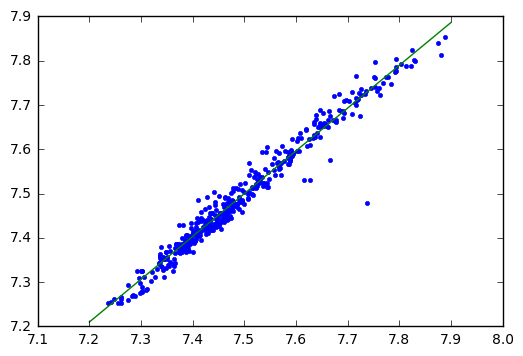

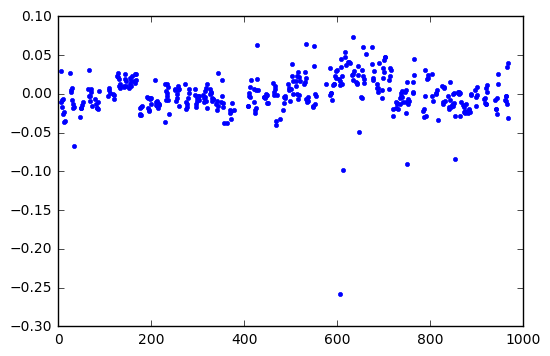

In [166]:
y_1 = coeff[0] + coeff[1]* pres + coeff[2]*temp + coeff[3]*sal + coeff[4]*oxy
#OR
y_1 = np.dot(A,coeff)

residual = y_1 - y
slope, intercept, r_value, p_value, std_err = stats.linregress(y,y_1)

fig,ax = plt.subplots()
ax.plot(y,y_1,'.')
x_line = np.linspace(7.2,7.9,299)
y_line = slope*x_line + intercept
ax.plot(x_line,y_line)

# Plot the residual
fig,ax = plt.subplots()
ax.plot(residual,'.')

print('R-Squared:',r_value**2)


In [153]:
res = sm.OLS(y, A).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 PH_TOT   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     2986.
Date:                Tue, 07 Mar 2017   Prob (F-statistic):          8.85e-305
Time:                        15:29:48   Log-Likelihood:                 959.88
No. Observations:                 421   AIC:                            -1910.
Df Residuals:                     416   BIC:                            -1890.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          7.0670      0.142     49.825      0.0

In [179]:
rmat = np.corrcoef(A)
print(np.shape(rmat))
# vif = 1/(1-rmat**2)
# print(vif)

(422, 422)
